### ML Models with Upsampling + SMOTE

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [3]:
# Load cleaned_df.csv file
cleaned_df = pd.read_csv('../data/clean/cleaned_df.csv')
# Read the file and its shape
display(cleaned_df.head())
print(cleaned_df.shape)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
1,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
2,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
3,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
4,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


(2011, 10)


### Dataset Split

In [4]:
# Separate the features from the target
y = cleaned_df['Potability']
X = cleaned_df.drop(['Potability'], axis=1)

### Train-Test Split

In [5]:
# Generate the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Balance Target Column

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
y_train_smote.value_counts()

Potability
0    845
1    845
Name: count, dtype: int64

In [7]:
# Concatenate X_train and y_train
trainset = pd.concat([X_train, y_train], axis=1)

In [8]:
# Unique value count of target column
trainset['Potability'].value_counts()

Potability
0    845
1    562
Name: count, dtype: int64

In [9]:
# Let's upsample the minority 
from sklearn.utils import resample
df_majority = trainset[trainset['Potability'] == 0]
df_minority = trainset[trainset['Potability'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
trainset1 = pd.concat([df_majority, df_minority_upsampled], axis=0)
trainset1

X_train_upsampled = trainset1.drop(['Potability'], axis =1)
y_train_upsampled = trainset1['Potability']

In [10]:
# Concatenate X_train_smote and X_train_upsampled
X_train1 = pd.concat([X_train_smote, X_train_upsampled])
X_train1.shape

(3380, 9)

In [11]:
# Concatenate y_train_smote and y_train_upsampled
y_train1 = pd.concat([y_train_smote, y_train_upsampled])
y_train1.shape

(3380,)

### Scale Columns

In [12]:
# Select StandardScaler
scaler = StandardScaler()

# Fit scaler with TRAIN data
scaler.fit(X_train1)

# Scale X_train_num_transformed with fitted scaler. Output is a np.array.
X_train_scaled = scaler.transform(X_train1)
X_test_scaled = scaler.transform(X_test)

# Add columns to np.array to create a DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, 
                                 columns=X_train1.columns, 
                                 index=X_train1.index)

X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                                columns=X_test.columns,
                                index=X_test.index)

### Model Selection

In [20]:
# Create models
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = KNeighborsClassifier()
model4 = AdaBoostClassifier()
model5 = GradientBoostingClassifier()


model_pipeline = [model1, model2, model3, model4, model5]
model_names = ['Logistic Regression', 'Random Forest Classifier', 'KNN', 'AdaBoostClassifier', 'GradientBoostingClassifier']

scores = {}

for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train_scaled_df, y_train1, cv=5))
    scores[model_name] = mean_score

print(scores)

{'Logistic Regression': 0.5292899408284024, 'Random Forest Classifier': 0.9674556213017752, 'KNN': 0.7775147928994084, 'AdaBoostClassifier': 0.6434911242603552, 'GradientBoostingClassifier': 0.7739644970414201}


### Playing with parameters

In [22]:
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, cohen_kappa_score

# Parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf' : [10, 20],
    'max_depth':[5, 10, 20],
}

# Multiple scoring metrics
scoring = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Kappa': make_scorer(cohen_kappa_score)
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, scoring=scoring, refit=False, cv=5)
grid_search.fit(X_train_scaled_df,y_train1)

# Retrieve best parameters and best score for each scoring metric
for metric_name in scoring.keys():
    print(f"Best parameters for {metric_name}:")
    index = grid_search.cv_results_['rank_test_' + metric_name].argmin()
    params = grid_search.cv_results_['params'][index]
    best_score = grid_search.cv_results_['mean_test_' + metric_name][index]
    print("Parameters:", params)
    print(f"Score: {best_score:.4f}")
    print("------")


Best parameters for Accuracy:
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 150}
Score: 0.9355
------
Best parameters for Precision:
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 150}
Score: 0.9738
------
Best parameters for Kappa:
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 150}
Score: 0.8710
------


In [13]:
#get predictions
clf = RandomForestClassifier(max_depth=20,
                             min_samples_split=15,
                             min_samples_leaf =10,
                             n_estimators=50,
                            bootstrap=False,
                            max_features='sqrt',
                            criterion='entropy')

clf.fit(X_train_scaled_df, y_train1)

print("The Accuracy for the Random Forest in the TRAIN set is {:.2f}".format(clf.score(X_train_scaled_df, y_train1)))
print("The Accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test_scaled_df, y_test)))

y_pred = clf.predict(X_test_scaled_df)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

The Accuracy for the Random Forest in the TRAIN set is 0.99
The Accuracy for the Random Forest in the TEST  set is 0.65


Potability
0    355
1    249
Name: count, dtype: int64

array([[259,  96],
       [117, 132]])

In [14]:
# Find other metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       355
           1       0.58      0.53      0.55       249

    accuracy                           0.65       604
   macro avg       0.63      0.63      0.63       604
weighted avg       0.64      0.65      0.64       604



### Feature Importance Rank

In [15]:
# Get the feature importances
rf_importances = list(zip(clf.feature_importances_, cleaned_df.columns))
rf_importances.sort(reverse=True)
# Print the feature rankings
rf_importances

[(0.16838370550606796, 'ph'),
 (0.1532883925866494, 'Sulfate'),
 (0.12112450375911489, 'Solids'),
 (0.11858657911549482, 'Chloramines'),
 (0.1119460673034457, 'Hardness'),
 (0.08610678886296246, 'Turbidity'),
 (0.08387280873766986, 'Trihalomethanes'),
 (0.08074886480245488, 'Organic_carbon'),
 (0.07594228932614003, 'Conductivity')]

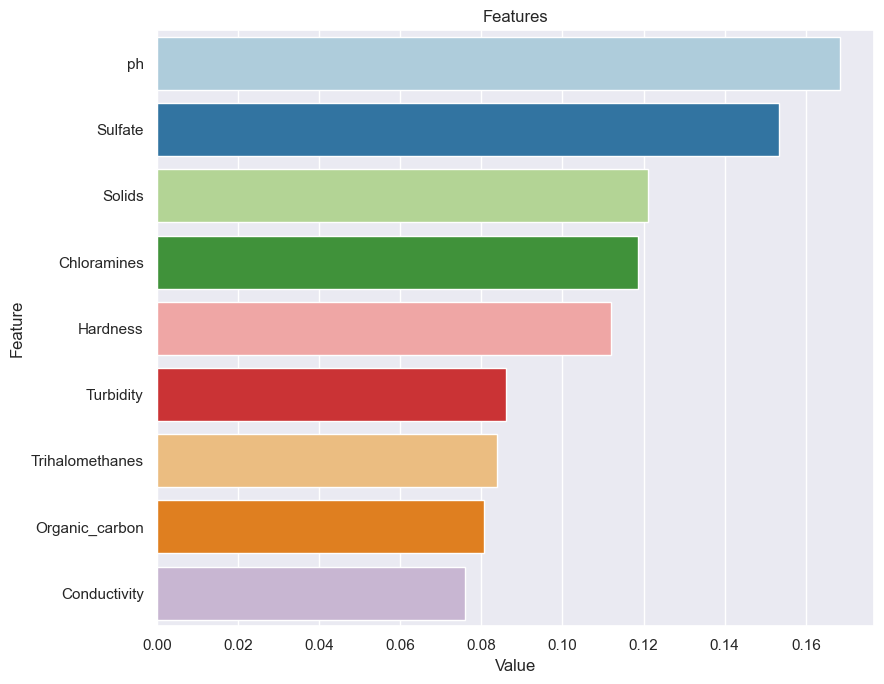

In [49]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(9, 7))
    sns.set(font_scale=1)
    custom_palette = sns.color_palette("Paired", 9)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False)[0:num], palette=custom_palette)
    plt.title('Features')
    plt.tight_layout()
    plt.show()

plot_importance(clf, X_train)

In [ ]:
# Save fig
plt.savefig("../Images/ph_distribution.png", dpi=300, bbox_inches='tight')

In [28]:
# creating a dataframe of the predictions y_pred
y_pred = clf.predict(X_test_scaled_df)
y_pred_df = pd.DataFrame(y_pred, columns=['Potability'], index=X_test_scaled_df.index)
y_pred_df

,Potability
1317,1
526,0
393,0
1405,1
433,0
...,...
1791,1
836,0
1642,1
1523,0
